<a href="https://colab.research.google.com/github/MIlanJP/Facial_emotion_detection__/blob/main/Facial_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Statement


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.


## Plan of Action
We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

**Face Emotion Recognition:**
This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.



# Importing Required Libraries


In [1]:
# Importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19, ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os 
tf.random.set_seed(42)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/archive.zip'

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [4]:
# Downloading the dataset
!gdown --id 1kdAI0wrR_bTBs-6p/bKB6giz-JcNaTY-s

# Unzipping the files
!unzip '/content/drive/MyDrive/archive.zip'

# Unzipping the files
# !unzip '/content/drive/MyDrive/archive.zip'# Defining te path of train and test dataset
train_dir = '/content/train'
test_dir = '/content/test'

# https://drive.google.com/file/d/1wzp2dRgA8fD6p8PEd8vVGdAOHd5-kQNo/view?usp=sharing

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

# 1. Data Augumentation <br>
  ### a. Training set <br>
  - Image Rotation
  - Rescaling
  - Shear Image
  - Zooming the Image
  - Horizontal Flip
  - Increasing Brightness


  ### b. Testing set
   - Rescaling

#2.Performing train test split 
## NOTE keeping the dimensions of the image 48 X 48 pixels (Grayscale)
- Train Split 27709
- Test Split  7178

In [13]:
# Generating batches of tensor image data with real-time data augmentation.
# setting the batch size for mini batch
batch = 64
# setting the dimensions for image
img = (48,48)


# Setting the Data Augumentation parameters for training data set 
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, rescale=1./255, shear_range=0.1,
                                                            zoom_range=0.2, horizontal_flip=True,
                                                            
                                                            brightness_range=(0.2, 0.8))

# Fetching the files from train directory and performing the data augumentation
train_data = train_gen.flow_from_directory(train_dir, target_size=img, batch_size=batch, class_mode = "categorical",
                                           color_mode="grayscale"
                                           )
# Setting the Data Augumentation parameters for validation data set 
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Fetching the files from test directory and performing the data augumentation
validation_data = validation_gen.flow_from_directory(test_dir, target_size=img, batch_size=batch*2, class_mode='categorical',
                                                     color_mode="grayscale"
                                                     )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


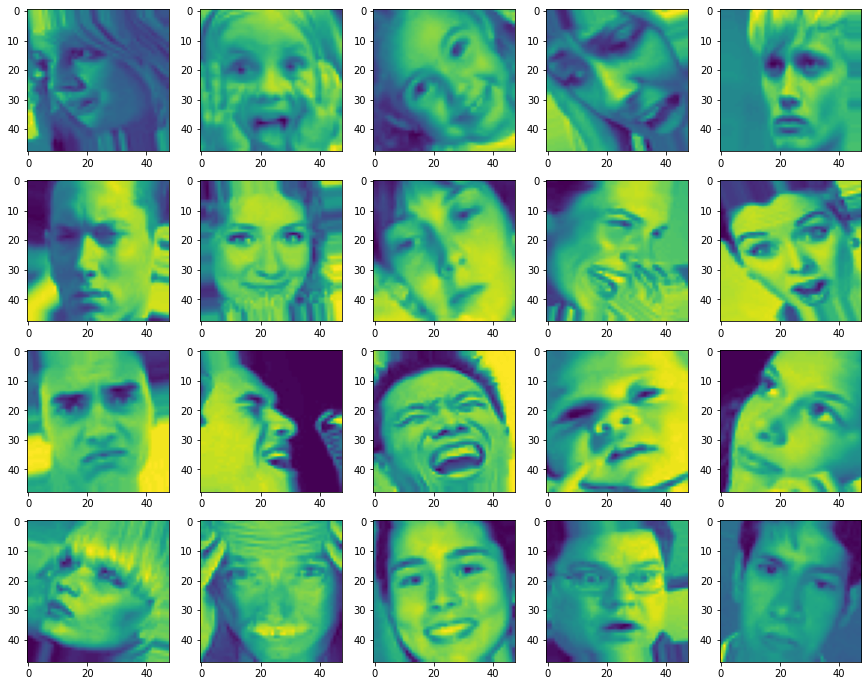

In [6]:
# Displaying sample images from the training set after augmentation
random_image = np.random.choice(64, size=20, replace=False)
random_batch = np.random.choice(112,size=20, replace=False)
fig,axes=plt.subplots(4,5,figsize=(15,12))
for id, ax in enumerate(axes.flatten()):
  pic = train_data[random_batch[id]][0][random_image[id]]
  ax.imshow(pic.reshape(48,-1))

## Model Building 

In [7]:
mobile_net=tf.keras.applications.VGG16(include_top=False,input_shape=(48,48,3))
last_layer=tf.keras.layers.Dense(7,activation='softmax')
base_output=mobile_net.layers[-4].output
base_output
resnet_url='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
# Defining a function to generate callbacks
def callback_list(name, esp=9, lrp=3):
    ''' Defining a function to generate the list of callbacks
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''
    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/{name}.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    # Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=esp, verbose=1, restore_best_weights=True)
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=lrp, verbose=1, min_delta=0.0001)
    # Defining a list of all the callbacks
    callbacks = [earlystop, checkpoint, reduce_lr]

    return callbacks


In [9]:
# Plot the training and validation accuracy and loss
def plots(history):
    ''' Defining a function to Plot the accuracy and loss
    Arguments:
        model.history
    Returns:
        plots of accuracy and loss for train and validation data
    '''
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()



<a name='2'></a>
# **Modified LeNet**

In [10]:
# Defining modeified Lenet architecture using keras sequential API
lenet = Sequential([# First CNN layer
                    Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # Second CNN layer
                    Conv2D(filters=16, kernel_size=3, activation='relu',  padding='same'),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # flattening and Adding 2 fully connected layers
                    Flatten(),
                    Dense(120, activation='relu'),
                    Dense(84, activation='relu'),
                    # using a prediction layer with seven neuron 
                    Dense(7, activation='softmax')])

# Compiling the model
lenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         60        
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                        

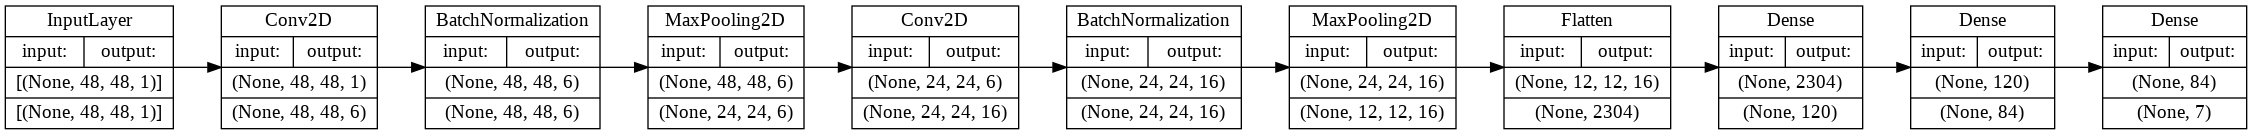

In [11]:
# Plot model graph
plot_model(lenet, show_shapes=True, to_file='lenet.png', rankdir='LR', show_layer_names=False)

In [15]:
# Fitting the model
lenet_history = lenet.fit(train_data, validation_data=validation_data, epochs=100, callbacks=callback_list('lenet'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.7908 - accuracy: 0.2815
Epoch 1: val_loss improved from inf to 1.77735, saving model to /content/drive/MyDrive/lenet.h5
449/449 [==============================] - 36s 56ms/step - loss: 1.7908 - accuracy: 0.2815 - val_loss: 1.7773 - val_accuracy: 0.3075 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.6764 - accuracy: 0.3382
Epoch 2: val_loss improved from 1.77735 to 1.64698, saving model to /content/drive/MyDrive/lenet.h5
449/449 [==============================] - 25s 55ms/step - loss: 1.6764 - accuracy: 0.3382 - val_loss: 1.6470 - val_accuracy: 0.3647 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.6257 - accuracy: 0.3638
Epoch 3: val_loss improved from 1.64698 to 1.62461, saving model to /content/drive/MyDrive/lenet.h5
449/449 [==============================] - 25s 55ms/step - loss: 1.6257 - accuracy: 0.3638 - val_loss: 1.6246 - v

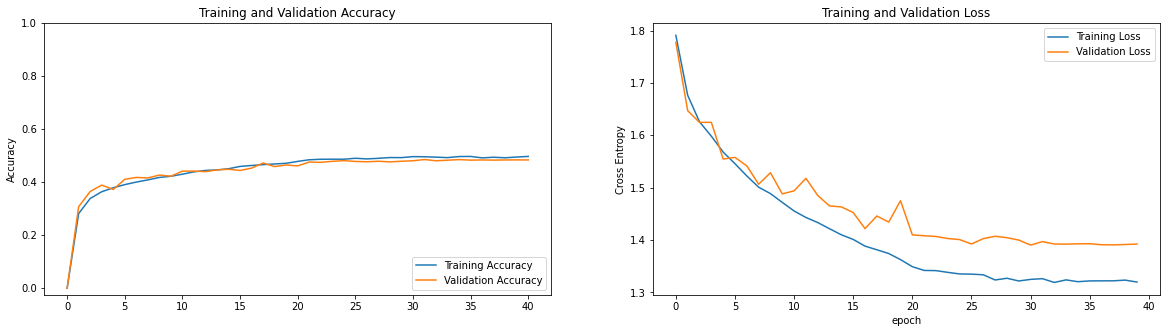

In [16]:
# Plotting te accuracy and loss
plots(lenet_history)

In [17]:
# AlexNet CNN architecture from scratch using keras sequential API
alexnet = Sequential([# The first block with 1 conv
                      Conv2D(96, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The second block with 1 conv
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The third block with 3 conv
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      MaxPool2D(pool_size=(2,2)),
                      # Flattening and Using 2 fully connected layer with 4096 units and relu activation
                      Flatten(),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      # Using a prediction layer with seven neuron
                      Dense(7, activation='softmax')])

# Compiling the model
alexnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 96)        960       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 256)       221440    
                                                                 
 batch_normalization_3 (Batc  (None, 24, 24, 256)      1024      
 hNormalization)                                                 
                                                      

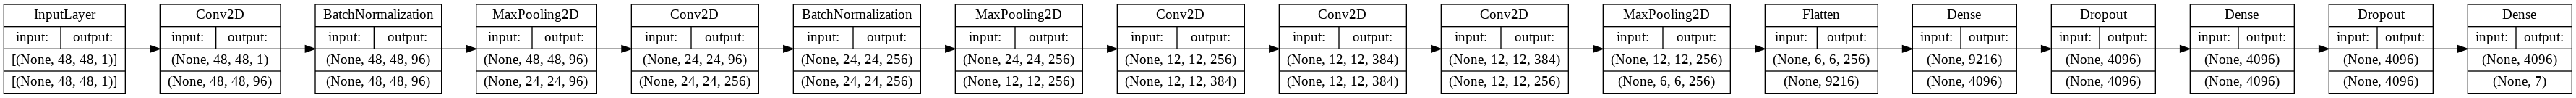

In [18]:
# Plot model graph
plot_model(alexnet, to_file='alexnet.png', show_shapes=True, rankdir='LR', show_layer_names=False)

In [20]:
# Fitting the model
alexnet_history = alexnet.fit(train_data, validation_data=validation_data, epochs=100, callbacks=callback_list('alexnet'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.7389 - accuracy: 0.2924
Epoch 1: val_loss improved from inf to 1.70040, saving model to /content/drive/MyDrive/alexnet.h5
449/449 [==============================] - 40s 82ms/step - loss: 1.7389 - accuracy: 0.2924 - val_loss: 1.7004 - val_accuracy: 0.3484 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5129 - accuracy: 0.4122
Epoch 2: val_loss improved from 1.70040 to 1.38093, saving model to /content/drive/MyDrive/alexnet.h5
449/449 [==============================] - 39s 87ms/step - loss: 1.5129 - accuracy: 0.4122 - val_loss: 1.3809 - val_accuracy: 0.4785 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.3582 - accuracy: 0.4784
Epoch 3: val_loss improved from 1.38093 to 1.27296, saving model to /content/drive/MyDrive/alexnet.h5
449/449 [==============================] - 40s 90ms/step - loss: 1.3582 - accuracy: 0.4784 - val_loss: 1.27

In [1]:
# Plotting te accuracy and loss
plots(alexnet_history)

NameError: ignored

In [ ]:
# mobile_net.layers[0].input
mod.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)     

In [ ]:
model=tf.keras.applications.

In [ ]:
# import tensorflow_hub as hub
mod=tf.keras.Sequential([
                         tf.keras.layers.Conv2D()
])




In [ ]:
module = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1")

NameError: ignored

In [ ]:
mod.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
mod.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 42, 42, 32)        320       
                                                                 
 conv2d_60 (Conv2D)          (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 21, 21, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 conv2d_62 (Conv2D)          (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                 

In [ ]:
result=mod.fit(train_data, validation_data=validation_data, epochs=50)

Epoch 1/50
  5/449 [..............................] - ETA: 9:53 - loss: 4.5077 - accuracy: 0.2000

KeyboardInterrupt: ignored

In [ ]:
from keras.backend import conv2d
import tensorflow_hub as hub
from tensorflow.keras import layers
def create_model(model_url,num_classes=7):

  feature_extractor=hub.KerasLayer(mobile_net,name='res_net_v2_feature_vector',input_shape=(48,48,3))

  model=tf.keras.Sequential([
                             layers.Conv2D(3,3),
                             feature_extractor,
                             layers.Dense(128,activation='relu'),
                             layers.Dense(64,activation='relu'),
                             layers.Dense(num_classes,activation='softmax',name='output_layers')                             
  ])
  return model
